In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# %matplotlib inline # Uncomment if running in a Jupyter environment

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from tensorflow.keras.applications import ResNet50 # Use ResNet50

# custom learning rates (definitions remain the same)
def decayed_learning_rate(step):
    if step <5: lr = 0.0001
    else: lr = 0.00005
    return lr
def decayed_learning_rate_tuned50(step): # Renamed from tuned20 for clarity with its name
    if step <5: lr = 0.0000001
    elif step <45: lr = 0.000005 # epochs2=20 means this condition will cover epochs 5-19
    else: lr = 0.000001
    return lr
# ... (all other learning rate functions remain the same) ...
def decayed_learning_rate_tuned20(step):
    if step <5: lr = 0.0000001
    elif step <15: lr = 0.000005
    else: lr = 0.000001
    return lr
def decayed_learning_rate_tuned30(step):
    if step <5: lr = 0.0000001
    elif step <25: lr = 0.000005
    else: lr = 0.000001
    return lr
def decayed_learning_rate_tuned75(step):
    if step <5: lr = 0.0000001
    elif step <70: lr = 0.000005
    else: lr = 0.000001
    return lr
def decayed_learning_rate_tuned100(step):
    if step <5: lr = 0.0000001
    elif step <95: lr = 0.000005
    else: lr = 0.000001
    return lr
def decayed_learning_rate_tuned150(step):
    if step <5: lr = 0.0000001
    elif step <145: lr = 0.000005
    else: lr = 0.000001
    return lr
def decayed_learning_rate_fixed1(step):
    if step <4: lr = 0.0000001
    elif step <5: lr = 0.0000005
    else: lr = 0.0005
    return lr
def decayed_learning_rate_fixed2(step):
    if step <4: lr = 0.0000001
    elif step <5: lr = 0.0000005
    else: lr = 0.000001
    return lr


# set the seeds for reproduceability
np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir = '/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images-10classes'
num_classes = 10

# learning params
epochs1 = 30
epochs2 = 30
learning_rate1_func = decayed_learning_rate # Assign the function itself
learning_rate2_func = decayed_learning_rate_tuned50 # Assign the function itself

batch_size = 32
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

2025-05-27 17:48:01.508938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748368081.720800      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748368081.783424      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# using ResNet50: load model without classifier layer, and using weights from ImageNet
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# For the initial training phase, freeze all layers in the base_model
base_model.trainable = False

# create model
model = Sequential()
model.add(base_model) # Add the entire ResNet50 base model as a single layer

I0000 00:00:1748368103.664834      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748368103.665528      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Add your custom top layers
model.add(BatchNorm()) # This BatchNorm is applied to the output of the base_model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model for the first training phase
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print("Model Summary (Initial Phase - Base Model Frozen):")
model.summary()

Model Summary (Initial Phase - Base Model Frozen):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,916,874 (95.05 MB)

 Trainable params: 1,323,018 (5.05 MB)

 Non-trainable params: 23,593,856 (90.00 MB)

In [4]:
# ImageDataGenerator setup (remains the same)
train_datagen = ImageDataGenerator(
                        rescale=1.0/255,
                        rotation_range=10,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.1,
                        zoom_range=0.05,
                        fill_mode='constant',
                        cval = 0,
                        validation_split=0.2
                    )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=(img_width, img_height), batch_size=batch_size,
    color_mode="rgb", class_mode='categorical', subset='training', shuffle=True, seed=13)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir, target_size=(img_width, img_height), batch_size=batch_size,
    color_mode="rgb", class_mode='categorical', subset='validation', shuffle=False, seed=13)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
print(f"Number of training samples: {nb_train_samples}")
print(f"Number of validation samples: {nb_validation_samples}")

# define callback for custom learning rate
callback1 = tf.keras.callbacks.LearningRateScheduler(learning_rate1_func)


Found 15844 images belonging to 10 classes.
Found 3957 images belonging to 10 classes.
Number of training samples: 15844
Number of validation samples: 3957


In [7]:
print("\n--- Starting Initial Training Phase (Top Layers) ---")
history1 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs1,
    callbacks=[callback1],
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size))

# --- Fine-tuning phase ---
# Unfreeze some layers in the base_model for fine-tuning.
# Your original logic was to unfreeze the first 12 layers of the base model.
# model.layers[0] is the base_model.
print(f"\nBase model name: {model.layers[0].name}")


--- Starting Initial Training Phase (Top Layers) ---
Epoch 1/30


I0000 00:00:1748368196.235856      98 service.cc:148] XLA service 0x7e349c013580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748368196.236851      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748368196.236873      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748368197.862016      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/496 ━━━━━━━━━━━━━━━━━━━━ 1:43:35 13s/step - accuracy: 0.2188 - loss: 3.2542

I0000 00:00:1748368202.213690      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


496/496 ━━━━━━━━━━━━━━━━━━━━ 162s 302ms/step - accuracy: 0.3341 - loss: 2.1266 - val_accuracy: 0.6429 - val_loss: 0.9938 - learning_rate: 1.0000e-04
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.5004 - loss: 1.5004 - val_accuracy: 0.6535 - val_loss: 1.0715 - learning_rate: 1.0000e-04
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.5320 - loss: 1.3515 - val_accuracy: 0.6879 - val_loss: 0.9561 - learning_rate: 1.0000e-04
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.5621 - loss: 1.2601 - val_accuracy: 0.6914 - val_loss: 0.9294 - learning_rate: 1.0000e-04
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.5755 - loss: 1.1872 - val_accuracy: 0.6990 - val_loss: 0.9153 - learning_rate: 1.0000e-04
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.5934 - loss: 1.1483 - val_accuracy: 0.7074 - val_loss: 0.8695 - learning_rate: 5.0000e-05
Epoch 7/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accur

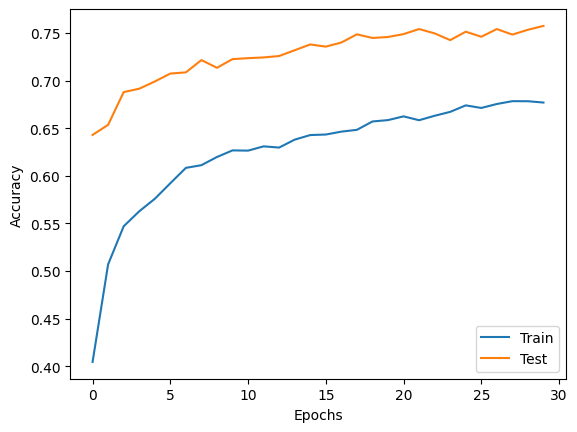

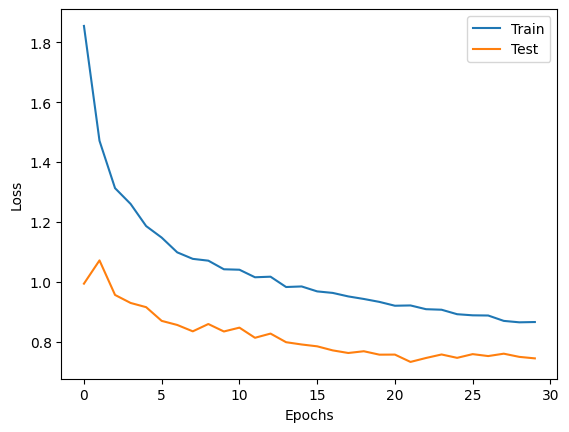

In [8]:
# plot the convergence, in terms of accuracy and loss, of HCR-RESNET34
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [9]:
# Allow the base_model block to be trainable
#model.layers[0].trainable = True

for layer in model.layers[0].layers[-40:]:
    layer.trainable = True


# The custom top layers (model.layers[1:]) are already trainable.

# Recompile the model with changes to trainable layers (optimizer state needs to be reset)
# It's good practice to use a lower learning rate for fine-tuning.
# The LearningRateScheduler will handle the LR.
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print("\nModel Summary (Fine-Tuning Phase - Early Base Layers Unfrozen):")
model.summary() # Check trainable parameters


Model Summary (Fine-Tuning Phase - Early Base Layers Unfrozen):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,916,874 (95.05 MB)

 Trainable params: 17,154,826 (65.44 MB)

 Non-trainable params: 7,762,048 (29.61 MB)

In [10]:
# define callback for custom learning rate for fine-tuning
callback2 = tf.keras.callbacks.LearningRateScheduler(learning_rate2_func)

# Reset generators
train_generator.reset()
validation_generator.reset()

print("\n--- Starting Fine-Tuning Phase ---")
history2 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs2,
    callbacks=[callback2],
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size))

# save model (optional) 
model.save_weights('HCR-ResNet50.h5')
model.save('HCR-ResNet50_model.keras')


--- Starting Fine-Tuning Phase ---
Epoch 1/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.1443 - loss: 3.0254 - val_accuracy: 0.1792 - val_loss: 3.2537 - learning_rate: 1.0000e-07
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.1426 - loss: 3.0163 - val_accuracy: 0.1890 - val_loss: 3.9014 - learning_rate: 1.0000e-07
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.1492 - loss: 2.9723 - val_accuracy: 0.1921 - val_loss: 3.8012 - learning_rate: 1.0000e-07
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.1545 - loss: 2.9573 - val_accuracy: 0.2002 - val_loss: 3.7840 - learning_rate: 1.0000e-07
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.1534 - loss: 2.9099 - val_accuracy: 0.2067 - val_loss: 3.6733 - learning_rate: 1.0000e-07
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.1938 - loss: 2.6602 - val_accuracy: 0.3947 - val_loss: 2.4331 - learning_rate: 5.0000e-06
Epoch 7/30
496/

ValueError: The filename must end in `.weights.h5`. Received: filepath=HCR-ResNet50.h5

In [12]:
epochs_completed_phase2 = 30 # Since you ran it for 10 epochs

# Target total number of epochs for this phase after continued training
target_total_epochs_phase2 = 50

print(f"\n--- Continuing Fine-Tuning Phase from epoch {epochs_completed_phase2 + 1} to {target_total_epochs_phase2} ---")

# The model 'model' is already compiled from the previous step.
# We reuse 'callback1' which uses 'learning_rate1_func'.
history2_continued = model.fit(
    train_generator,  # Use the same training data generator
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=target_total_epochs_phase2,  # Train until the 20th epoch for this phase
    initial_epoch=epochs_completed_phase2,  # Start counting from epoch 10 (0-indexed)
    callbacks=[callback2],  # Reuse the same learning rate scheduler for this phase
    validation_data=validation_generator,  # Use the same validation data
    validation_steps=math.ceil(nb_validation_samples / batch_size)
)


--- Continuing Fine-Tuning Phase from epoch 31 to 50 ---
Epoch 31/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.6258 - loss: 1.0150 - val_accuracy: 0.7420 - val_loss: 0.7564 - learning_rate: 5.0000e-06
Epoch 32/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.6423 - loss: 0.9710 - val_accuracy: 0.7427 - val_loss: 0.7187 - learning_rate: 5.0000e-06
Epoch 33/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.6497 - loss: 0.9568 - val_accuracy: 0.7513 - val_loss: 0.6982 - learning_rate: 5.0000e-06
Epoch 34/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.6548 - loss: 0.9378 - val_accuracy: 0.7412 - val_loss: 0.6983 - learning_rate: 5.0000e-06
Epoch 35/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.6625 - loss: 0.9332 - val_accuracy: 0.7559 - val_loss: 0.6850 - learning_rate: 5.0000e-06
Epoch 36/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.6573 - loss: 0.9028 - val_accuracy: 0.7501 - val_loss: 0.6688 - learning_rate:

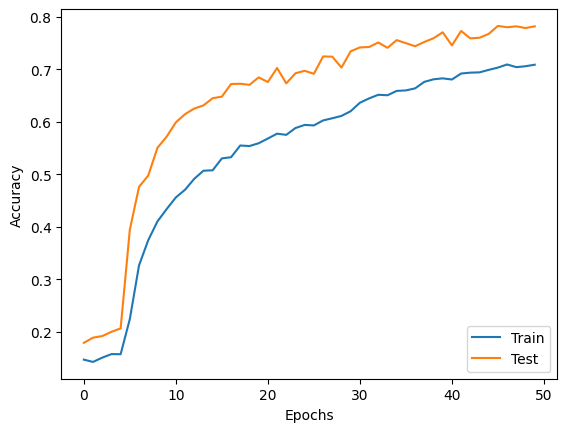

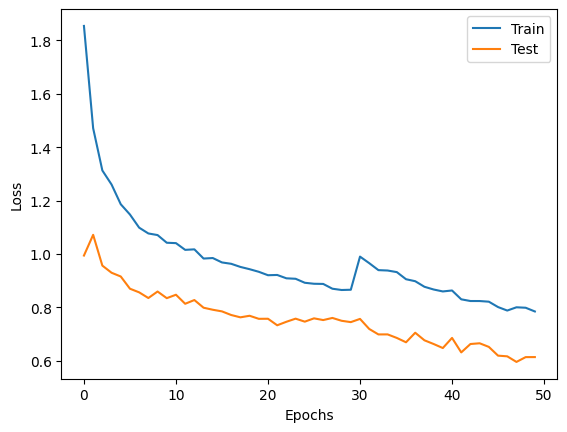

124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step


<Axes: >

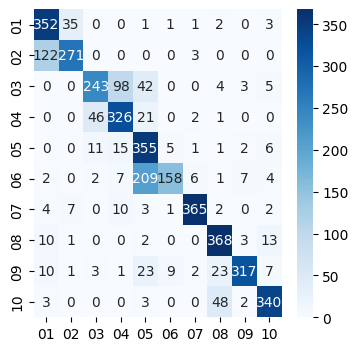

In [13]:
# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history2.history['accuracy']+history2_continued.history['accuracy'])
plt.plot(history2.history['val_accuracy']+history2_continued.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2_continued.history['loss'])
plt.plot(history1.history['val_loss']+history2_continued.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')